/tmp/ipykernel_14444/3443789561.py:101: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsxkxtem9/ua7jev3u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsxkxtem9/b_99g2y8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/agsa/Documents/Projects/Personal_projects/Forecasting_ML_microservice/train/.venv/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64445', 'data', 'file=/tmp/tmpsxkxtem9/ua7jev3u.json', 'init=/tmp/tmpsxkxtem9/b_99g2y8.json', 'output', 'file=/tmp/tmpsxkxtem9/prophet_model4zjjgkq7/prophet_model-20250407125701.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:57:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:57:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done proces

Data range: 2013-01-02 00:00:00 -> 2015-01-23 00:00:00
Total days: 751


INFO:prophet:Making 1 forecasts with cutoffs between 2014-07-27 00:00:00 and 2014-07-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.thread.ThreadPoolExecutor object at 0x7fc51a5378b0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsxkxtem9/f72426sj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsxkxtem9/j306umnr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/agsa/Documents/Projects/Personal_projects/Forecasting_ML_microservice/train/.venv/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15803', 'data', 'file=/tmp/tmpsxkxtem9/f72426sj.json', 'init=/tmp/tmpsxkxtem9/j306umnr.json', 'output', 'file=/tmp/tmpsxkxtem9/prophet_modeljek4n_is/prophet_model-20250407125701.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:57:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:57:01 - cmdstanpy - INFO - Chain [1] done processin

🏃 View run grandiose-tern-605 at: http://127.0.0.1:5000/#/experiments/968625720454172738/runs/68015ceb33ca43f78e34f56660b59e81
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/968625720454172738


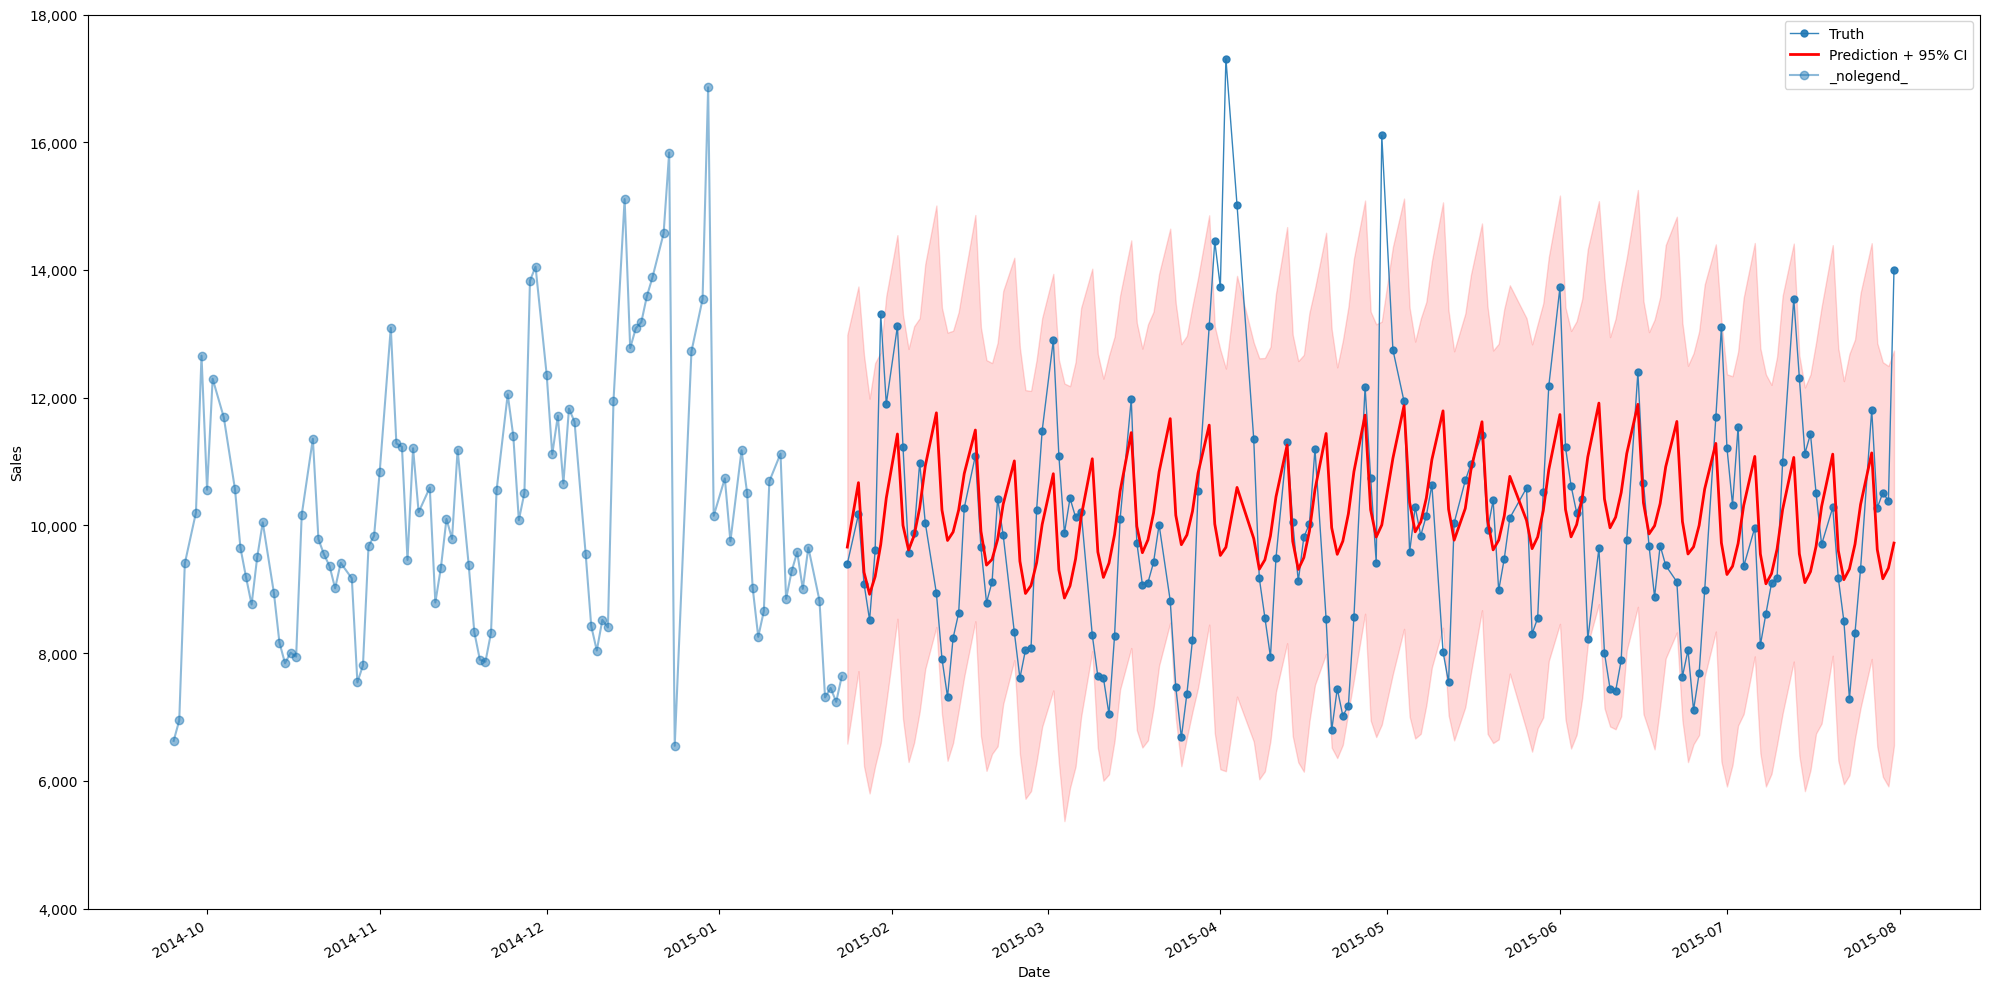

In [ ]:
import os
import logging
import kaggle
import pandas as pd
from prophet import Prophet, serialize
import matplotlib.pyplot as plt
from pathlib import Path
from prophet.diagnostics import cross_validation, performance_metrics

import mlflow
from mlflow.models import infer_signature

# config kaggle json and download the dataset.
def download_kaggle_dataset(kaggle_dataset: str = "pratyushakar/rossmann-store-sales") -> None:
    kaggle.api.dataset_download_files(kaggle_dataset, path='./data', unzip=True, quiet=False)

def prep_store_data(df: pd.DataFrame, store_id: int = 4, store_open: int = 1) -> pd.DataFrame:
    df["Date"] = pd.to_datetime(df["Date"])
    df.rename(columns = {"Date": "ds", "Sales": "y"}, inplace=True)
    df_store = df[
        (df["Store"] == store_id ) &\
        (df["Open"] == store_open)
    ].reset_index(drop=True)
    return df_store.sort_values("ds", ascending=True)

def train_test_split(df: pd.DataFrame, train_fraction: float) -> tuple[pd.DataFrame, pd.DataFrame, int]:
    train_index = int(train_fraction*df.shape[0])
    df_train = df.copy().iloc[0:train_index]
    df_test = df.copy().iloc[train_index:]
    return df_train, df_test, train_index


def plot_forecast(df_train: pd.DataFrame, df_test: pd.DataFrame, predicted: pd.DataFrame, train_index: int, results_path: str) -> None:
    fig, ax = plt.subplots(figsize=(20, 10))
    df_test.plot(
        x="ds",
        y="y",
        ax=ax,
        label="Truth",
        linewidth=1,
        markersize=5,
        color="tab:blue",
        alpha=0.9,
        marker="o"
    )
    predicted.plot(
        x="ds",
        y="yhat",
        ax=ax,
        label="Prediction + 95% CI",
        linewidth=2,
        markersize=5,
        color="red"
    )
    ax.fill_between(
        x=predicted["ds"],
        y1=predicted["yhat_upper"],
        y2=predicted["yhat_lower"],
        alpha=0.15,
        color="red"
    )
    df_train.iloc[train_index-100:].plot(
        x="ds",
        y="y",
        ax=ax,
        color='tab:blue',
        label="_nolegend_",
        alpha=0.5,
        marker="o",
    )
    
    yticks = plt.gca().get_yticks()
    ax.set_yticks(yticks)
    ax.set_yticklabels(["{:,.0f}".format(x) for x in yticks])
    ax.set_xlabel("Date")
    ax.set_ylabel("Sales")
    plt.tight_layout()
    plt.savefig(os.path.join(results_path, "store_data_forecast.png"))

def extract_params(pr_model):
    return {attr: getattr(pr_model, attr) for attr in serialize.SIMPLE_ATTRIBUTES}

def main():

    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    mlflow.set_experiment("prophet_models_04042025")
    # mlflow.autolog()

    results_path = "./results/"
    Path(results_path).mkdir(exist_ok=True)
    data_path = "./data/"
    train_file = "train.csv"
    file_path = os.path.join(data_path, train_file)

    if os.path.exists(file_path):
        logging.info("Dataset already exists!")
    else:
        logging.info("Dataset not found, Downloading ...")
        download_kaggle_dataset()

    df = pd.read_csv(file_path)
    df = prep_store_data(df)

    seasonality = {
        "yearly": True,
        "weekly": True,
        "daily": False,
    }
    ARTIFACT_PATH = "model"

    with mlflow.start_run():
        df_train, df_test, train_index = train_test_split(df, train_fraction=0.8)
        
        print(f"Data range: {df_train['ds'].min()} -> {df_train['ds'].max()}")
        print(f"Total days: {(df_train['ds'].max() - df_train['ds'].min()).days}")
        
        model = Prophet(
            yearly_seasonality = seasonality["yearly"],
            weekly_seasonality = seasonality["weekly"],
            daily_seasonality = seasonality["daily"],
            interval_width = 0.95
        )

        model.fit(df_train)
        predicted = model.predict(df_test)
        
        train = model.history
        signature = infer_signature(train, predicted)
        
        mlflow.prophet.log_model(model, artifact_path=ARTIFACT_PATH, signature=signature) # or signature=False, input_example= df_train

        metric_keys = ["mse", "rmse", "mae", "mape", "mdape", "smape", "coverage"]
        metrics_raw = cross_validation(
            model=model,
            horizon = "180 days",
            period = "90 days",
            initial = "500 days",
            parallel="threads",
            disable_tqdm=True,
        )
        cv_metrics = performance_metrics(metrics_raw)
        metrics = {k: cv_metrics[k].mean() for k in metric_keys}
    
        params = extract_params(model)
        mlflow.log_params(params)
        mlflow.log_metrics(metrics)

        plot_forecast(df_train, df_test, predicted, train_index, results_path)


if __name__ == "__main__":
    main()
